In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import pingouin as pg
from nilearn import plotting
from matplotlib.colors import LogNorm

from src import data

%matplotlib widget

!date -I

2024-04-09


In [2]:
plt.rcParams['figure.figsize'] = [15, 5]

## Structural connectivity - Glasser parcellation

- SC Rosen-Halgren s Glasser parcelací vychází nejlépe, pojďme zjistit, jak to
- Glasser: <https://neuroimaging-core-docs.readthedocs.io/en/latest/pages/atlases.html#id4>
- Ros-Hal: <https://zenodo.org/records/10150880>???, data, se kterými jsem pracovala původně: <https://zenodo.org/records/6097026>


### Load structural (and functional) connectivity data

In [3]:
ED = data.glasser_roi_distances()
SC_W_RH, SC_L_RH = data.load_rosen_halgren()
SC_W_M,SC_L_M = data.load_mica("glasser360",360,mode="rh_averaging")
glasser_labels = data.ftract_compatible_glasser_labels()

In [13]:
def plot_adjacency_matrix(matrix,ax,title,norm=None,mask=None):

    g =sns.heatmap(matrix,ax=ax,square=True,cbar=False,yticklabels=False, xticklabels=False,cmap='gray',norm=norm,mask=mask)
    g.set_facecolor('k')
    ax.set_title(title)

# Structural connectivity - weights

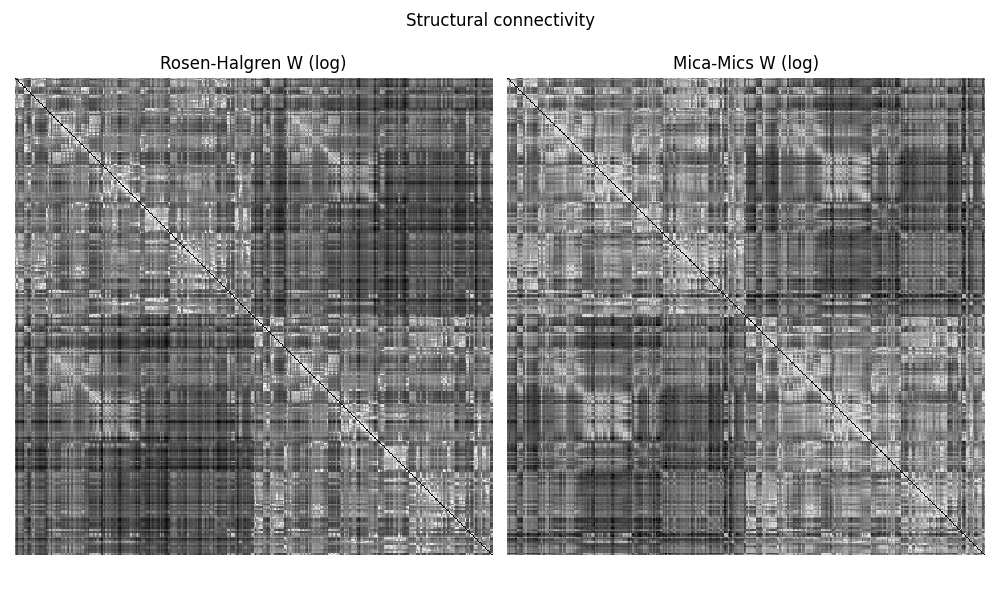

No such comm: 6b0499cf48254f32a2f12fbf2a97da45
No such comm: 6b0499cf48254f32a2f12fbf2a97da45
No such comm: 6b0499cf48254f32a2f12fbf2a97da45


In [15]:
fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(10,6),sharey=True,sharex=True)
fig.suptitle("Structural connectivity")
plot_adjacency_matrix(SC_W_RH,axs[0],"Rosen-Halgren W (log)",mask=SC_W_RH==0)
plot_adjacency_matrix(SC_W_M,axs[1],"Mica-Mics W (log)",norm=LogNorm(),mask=SC_W_M==0)

In [16]:
pg.corr(SC_W_RH.flatten(),SC_W_M.flatten(),method='spearman')

,n,r,CI95%,p-val,power
spearman,129240,0.825646,"[0.82, 0.83]",0.0,1.0


In [7]:
df = pd.DataFrame({'1':np.log10(SC_W_RH1).flatten(),'2':SC_W_RH2.flatten()})

/tmp/ipykernel_43801/1144876629.py:1: RuntimeWarning: divide by zero encountered in log10
  df = pd.DataFrame({'1':np.log10(SC_W_RH1).flatten(),'2':SC_W_RH2.flatten()})


In [8]:
pg.pairwise_corr(df)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,1,2,pearson,two-sided,129240,0.987658,"[0.99, 0.99]",0.0,nan,1.0


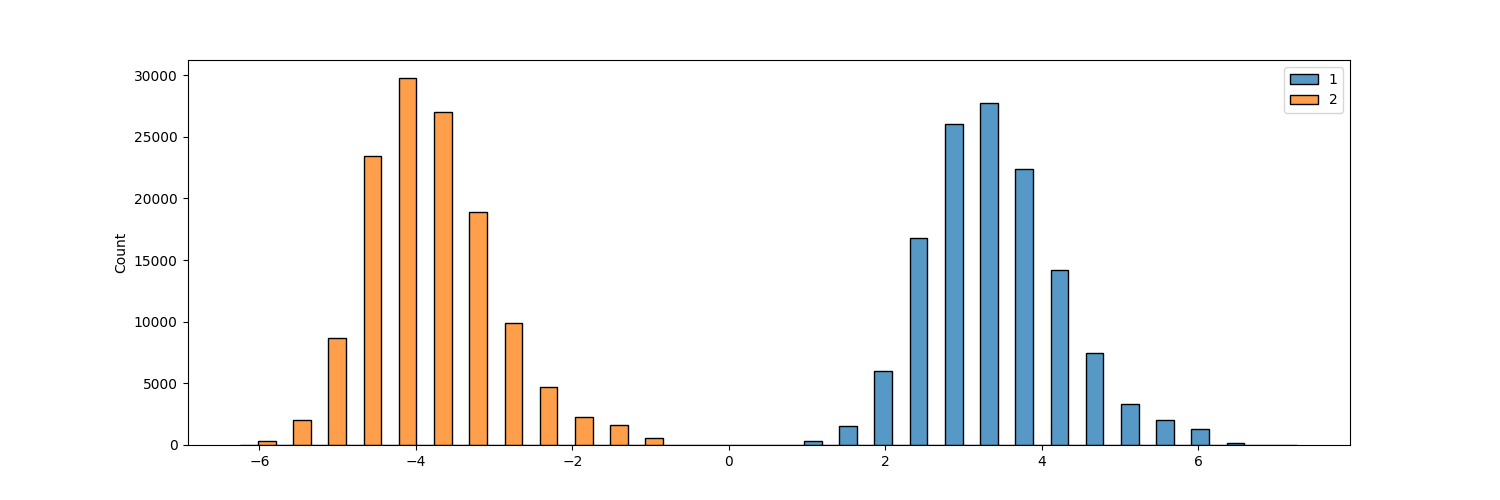

In [9]:
plt.figure()
sns.histplot(df,multiple='dodge',bins = 30)
plt.show()

In [10]:
def get_lengths(matrix,ED):
    np.fill_diagonal(ED,np.nan)
    mask = matrix > 0
    return np.where(mask,ED,np.nan).flatten()

df_len = pd.DataFrame({"1":get_lengths(SC_W_RH1,ED),"2":get_lengths(SC_W_RH2,ED)})

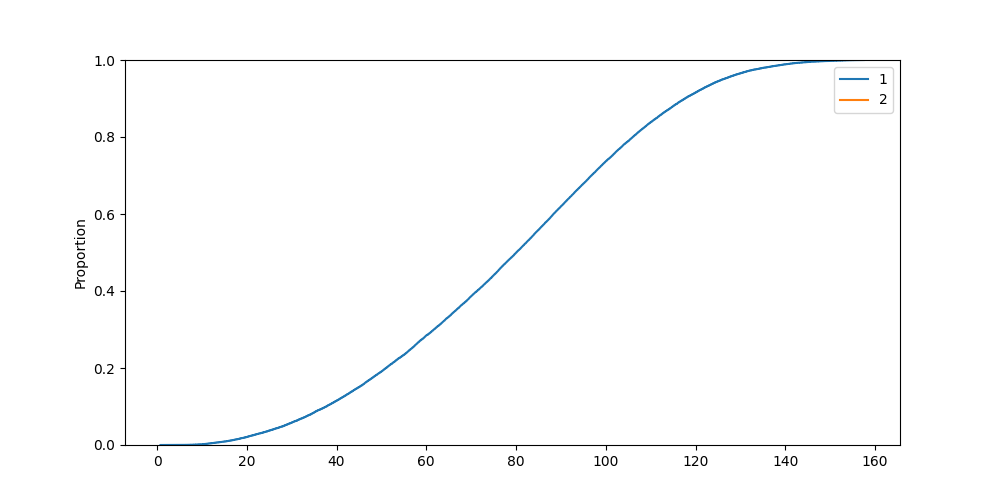

In [11]:
plt.figure(figsize=(10,5))
sns.ecdfplot(df_len)
plt.show()

# Create SC matrix from MICA-MICS

In [28]:
import os

path_to_dir = paths.path('external/mica-mics/sc_glasser')
number_of_subjects = 50

M = np.zeros((50,360,360))

index = list(range(15,195)) + list(range(196,376))

for i in range(number_of_subjects):
    counts_file = path_to_dir+f"/sub-HC{i+1:03d}_ses-01_space-dwinative_atlas-glasser360_desc-sc.txt"
    with open(counts_file,"r") as cf:
        c = np.genfromtxt(cf,delimiter=',')
        c = np.take(c,indices=index,axis=0)
        c = np.take(c,indices=index,axis=1)
        M[i] = c + c.T

/tmp/ipykernel_43801/3172574745.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(M[42]))


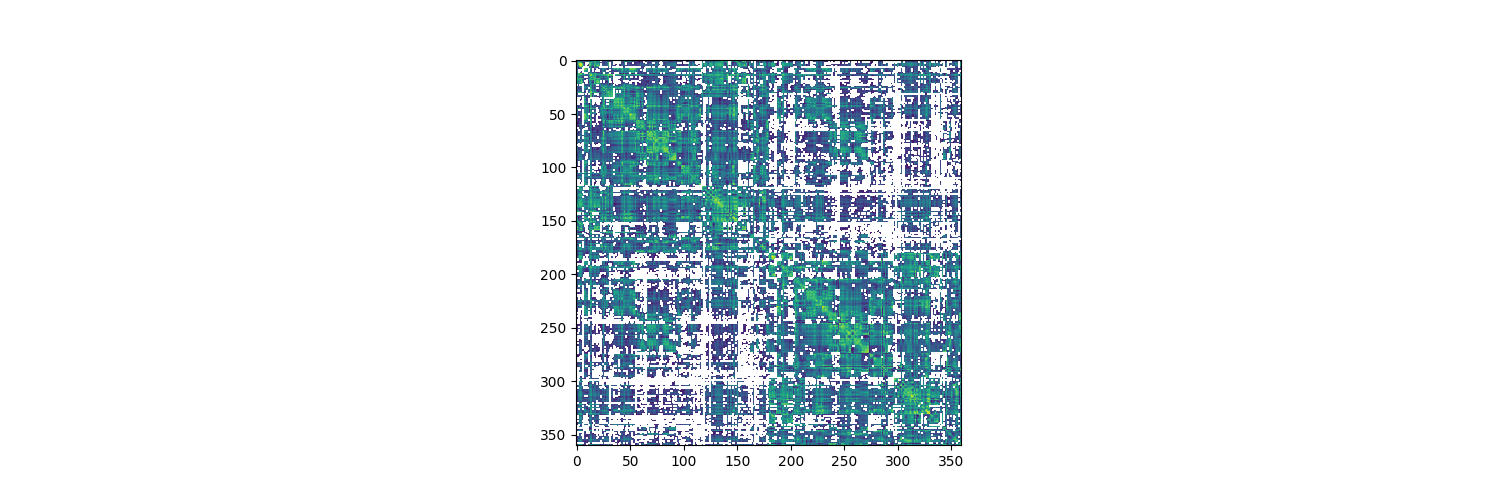

In [29]:
plt.figure()
plt.imshow(np.log(M[42]))
plt.show()

In [37]:
M_mean = np.mean(M,axis=0)
SC = np.zeros(M_mean.shape)

for i in range(360):
    for j in range(360):
        SC[i][j] = M_mean[i][j] / (np.sum(M_mean[i,:]) + np.sum(M_mean[:,j]) - M_mean[i][i] - M_mean[j][j])

np.fill_diagonal(SC,np.nan)

print(pg.corr(SC.flatten(),SC_W_RH2.flatten(),method='spearman'))

# vypadá to, že je to ok, ale kdyby bylo něco k těm indexům někde napsáno, tak bych se nezlobila

               n         r         CI95%  p-val  power
spearman  129240  0.825646  [0.82, 0.83]    0.0    1.0


/tmp/ipykernel_43801/1123566848.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(SC))


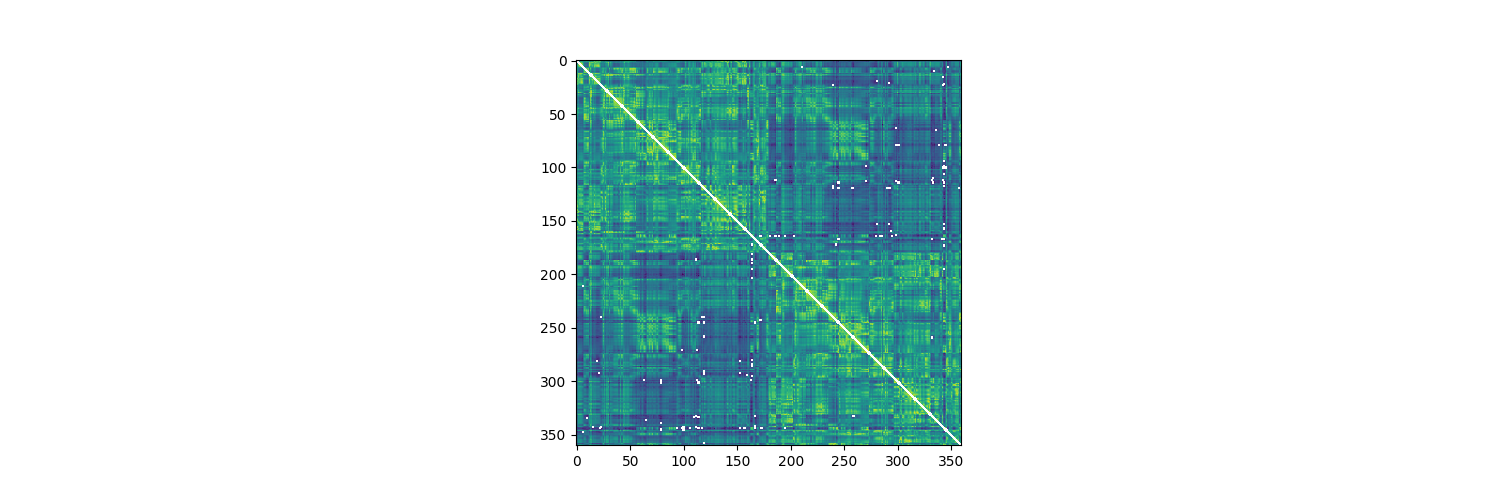

In [39]:
plt.figure()
plt.imshow(np.log(SC))
plt.show()

In [41]:
np.save("test.npy",np.log10(SC))

/tmp/ipykernel_43801/4021108226.py:1: RuntimeWarning: divide by zero encountered in log10
  np.save("test.npy",np.log10(SC))
